In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

from xrdc import xrdutils
from xrdc import source_separation as sep
from xrdc import featurization as feat
from xrdc import visualization as vis
from xrdc import peak_fitting as pf
from xrdc import workflows

from scipy.ndimage.filters import gaussian_filter as gf

Loading Data from: /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/inputs/
Data Loaded Succesfully
(177, 800)
/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig


In [2]:
basepath = "../../../datasets/nate/casettes/"

from glob import glob
import os

paths = glob(basepath + '*csv')

datasets = ([pd.read_csv(p) for p in paths])

In [3]:
threshold = 15
bg_smooth = 0
bg_smooth_post = 20

patterns = pd.DataFrame(d['I'] for d in datasets)
patterns = patterns.values

background, fast_q, slow_T, fast_T = sep.separate_signal(patterns, background_after_filter = False,
                                 threshold = threshold, smooth_q = 1.7, smooth_neighbor_background = 0,
                                smooth_q_background = bg_smooth,
                                 bg_fill_method = 'simple')


(0, 0)


Aggregate-level uncertainty--i.e. pointwise uncertainty in the average over all patterns--is estimated from the distribution of noise and background estimates.

In [4]:
N = len(patterns)
aggregate_uncertainty = np.sqrt((fast_T.std(axis = 0)**2 + background.std(axis = 0)**2) / N)
background = gf(background, (0, bg_smooth_post))
aggregate_uncertainty = gf(aggregate_uncertainty, bg_smooth_post)

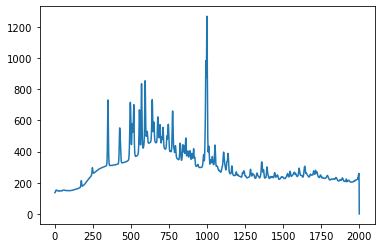

In [5]:
%matplotlib inline
plt.plot(patterns[10])

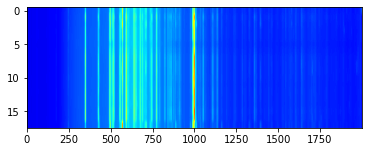

In [6]:
plt.imshow(patterns, aspect = 40, cmap = 'jet')

In [7]:
%matplotlib inline
sep.iplot_rows(patterns, fast_q, background, labels = ['raw', 'extracted'])

interactive(children=(IntSlider(value=8, description='i', max=17), Output(layout=Layout(height='550px'))), _do…

In [8]:
# background_post, fast_q_post, slow_T_post, fast_T_post = sep.separate_signal(patterns.sum(axis = 0)[:, None].T,
#                                 background_after_filter = True, threshold = threshold, smooth_q = 1.7,
#                                 smooth_neighbor_background = 0, smooth_q_background = bg_smooth,
#                                 bg_fill_method = 'simple')

### Summed XRD. Green curve here shows estimated aggregate-level uncertainty:

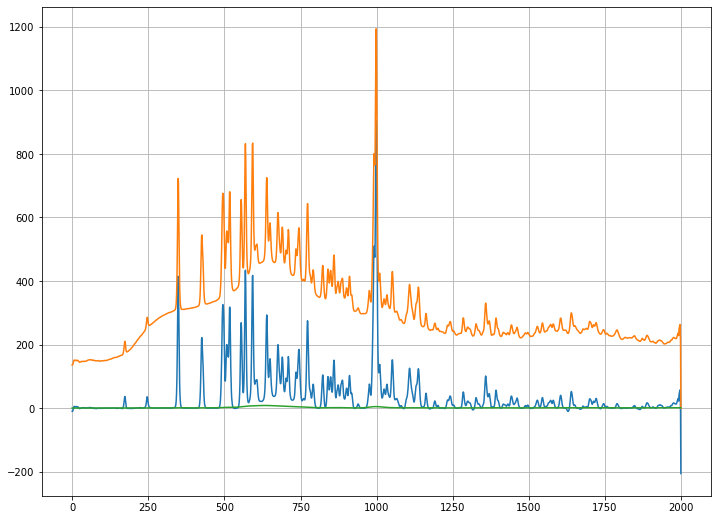

In [9]:
#plt.plot(background.std(axis = 0) / np.sqrt(N))
# plt.plot(fast_T.std(axis = 0) / np.sqrt(N))
plt.plot(fast_q.mean(axis = 0))
plt.plot(patterns.mean(axis = 0), label = 'raw XRD, averaged')
plt.plot(aggregate_uncertainty)
plt.grid()

# Peak fitting

Sketch of what's happening below: 

* We run the signal extraction on individual XRD patterns
* For each q point we consider two contributions to the uncertainty: (1) extracted noise (fast_T) and (2) jitter in the background estimate. At the *aggregate* level we can calculate standard errors for both of these and sum them in quadrature. 
* We run peak fitting on the average of of raw XRD patterns. We pass the average background and aggregate uncertainty calculated in the above two steps to the BBA + peak-fitting routine.  

In [10]:
np.random.seed(42)

In [11]:
def get_curves(fitoutput, i, j, peak_range_only = True):
    # TODO clean up
    arrays, paramsLists, noiselists, xLists, yLists, curveparams = fitoutput

    x, y, cparams = xLists[i][j], yLists[i][j], curveparams[i][j]

    # y values for individual Voigts
    ys = pf.hitp.gen_curve_fits(x, y, cparams, 'Voigt')

    X, Y = np.hstack(xLists[i]), np.hstack(yLists[i])
    bounds = [onex[0] for onex in xLists[i]]
    if peak_range_only:
        mask = (X >= x.min()) & (X <= x.max())
        return x, y, X[mask], Y[mask], ys, bounds
    else:
        return x, y, X, Y, ys, bounds
    
def mean2d(arr2d):
    return arr2d.mean(axis = 0)[:, None].T

In [12]:
%%capture
stdratio_threshold = 3

# fsub_stop_2d_0 = pf.curvefit_2d(mean2d((patterns - 0)), stdratio_threshold = stdratio_threshold,
#                 noise_estimate = aggregate_uncertainty[:, None].T, background = mean2d(background),
#                 bg_shift_pos = True, fit_sigma = False)

# fit_sigma = True passes the estimated uncertainty to the scipy.fit_curve
fsub_stop_2d_1 = pf.curvefit_2d(mean2d(patterns - 0), stdratio_threshold = stdratio_threshold,\
                                noise_estimate = aggregate_uncertainty[:, None].T, background = mean2d(background),\
                                bg_shift_pos = True, fit_sigma = True, reg_scale = 1e-2);

In [13]:
reload(pf.hitp)
reload(pf)

/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig


<module 'xrdc.peak_fitting' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/peak_fitting.py'>

<IPython.core.display.Javascript object>


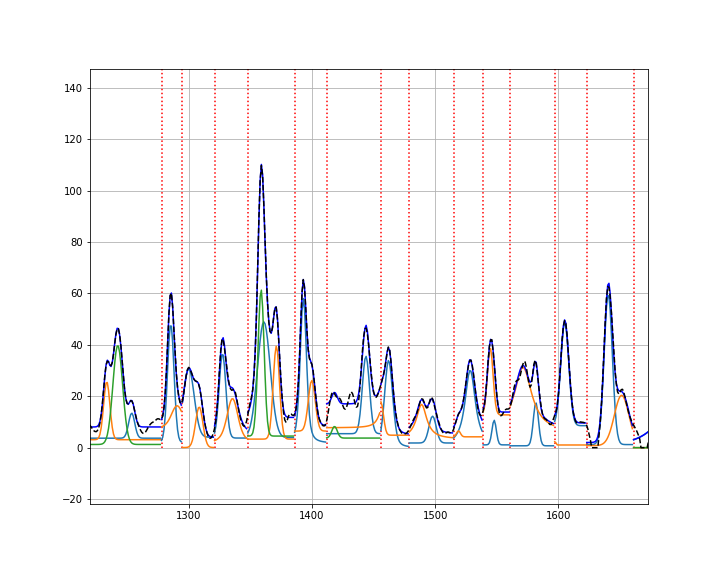

In [17]:
%matplotlib notebook
def plot_all_fits(fsub_stop_2d_1, i):
    arrays, paramsLists, noiselists, xLists, yLists, curveparams = fsub_stop_2d_1

    Ys = []
    yss = []
    for j in range(len(xLists[i])):
        x, y, X, Y, ys, bounds = get_curves(fsub_stop_2d_1, i, j)
        yss.append(ys)
        Ys.append(Y)
        plt.gca().set_prop_cycle(None)
        for k, yk in enumerate(ys[:-1]):
            plt.plot(x, yk, label = k)
        plt.plot(x, ys[-1], label = 'total fits', color = 'blue')

    _, _, X, Y, _, _ = get_curves(fsub_stop_2d_1, i, j, peak_range_only=False)
    plt.plot(X, Y, '--', color = 'k')
    plt.grid()
    plt.vlines(bounds, 0, 800, color = 'red', linestyles = 'dotted')
    return Ys, yss
plot_all_fits(fsub_stop_2d_1, 0);

In [18]:
#i, j = 0, 15
i, j = 0, 50

x, y, X, Y, ys, bounds = get_curves(fsub_stop_2d_1, i, j, False)

<IPython.core.display.Javascript object>


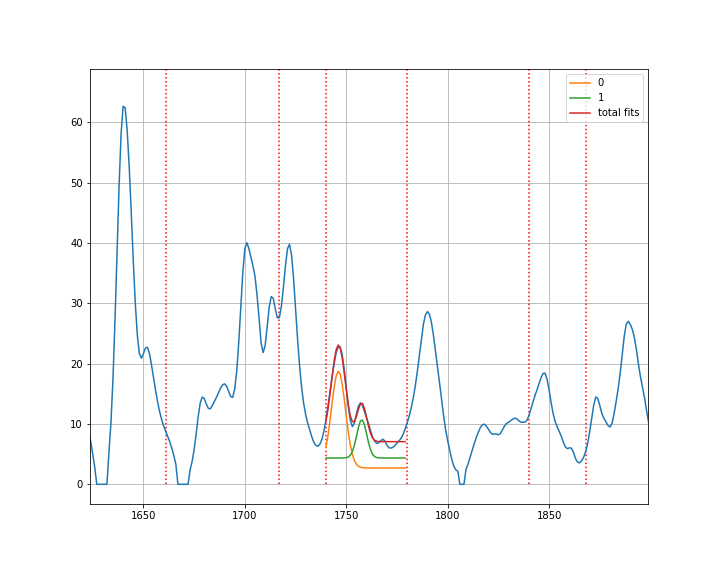

In [19]:
%matplotlib notebook
plt.plot(X, Y)
for j, yj in enumerate(ys[:-1]):
    plt.plot(x, yj, label = j)
plt.plot(x, ys[-1], label = 'total fits')
plt.vlines(bounds, 0, 800, color = 'red', linestyles = 'dotted')
plt.legend()
plt.grid()

## Regularization

Voigt offsets vary from run to run (depending on random seed) and are often negative. We can pin them down by adding a regularization to the objective function such as: 

$
-\lambda \min(y0, y1, ..., 0)
$

where y0, etc. are offsets.

(using something different/more robust now, will update this text)

Before
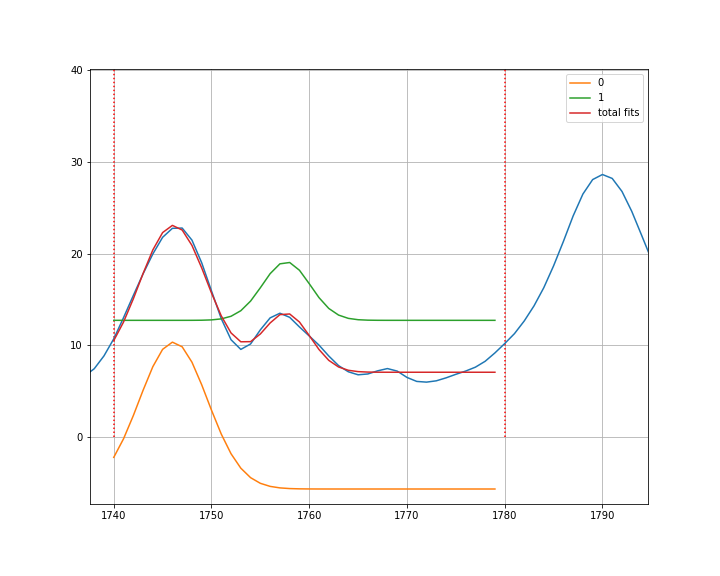

After
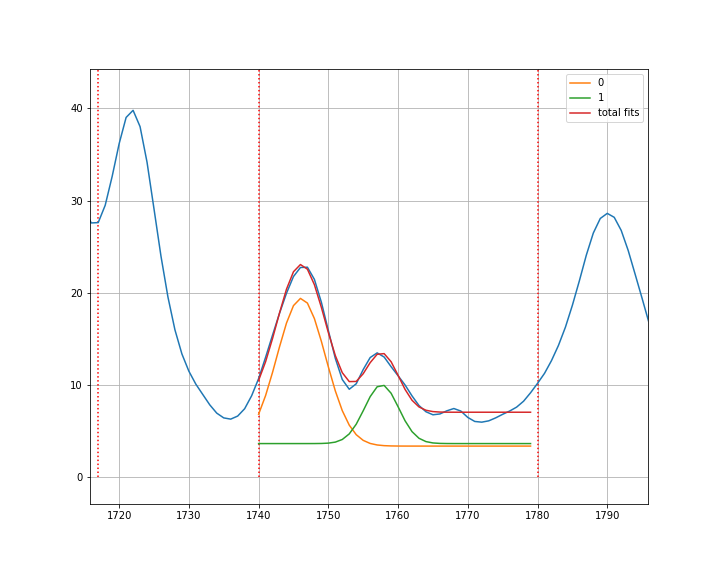

Before
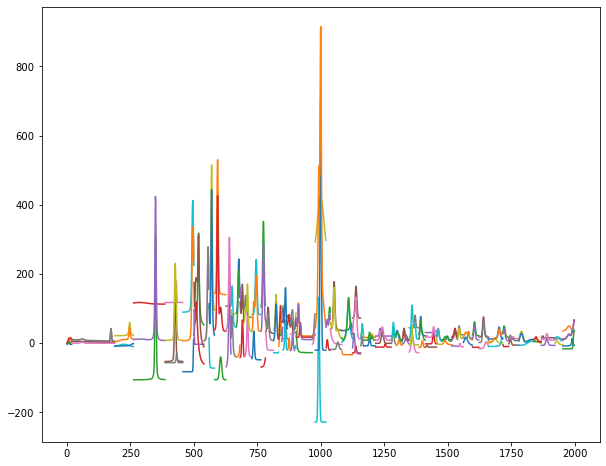

After
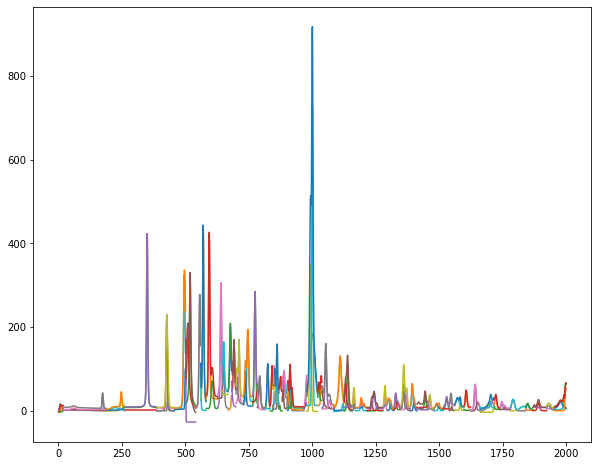

<IPython.core.display.Javascript object>


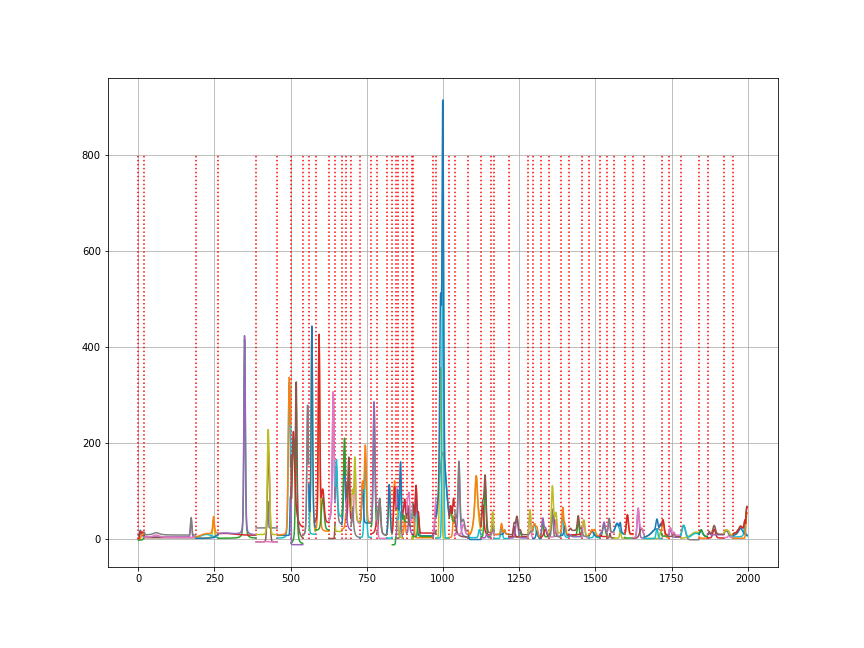

In [89]:
%matplotlib notebook
arrays, paramsLists, noiselists, xLists, yLists, curveparams = fsub_stop_2d_1

Ys = []
Xs = []
yss = []
for j in range(len(xLists[i])):
    x, y, X, Y, ys, bounds = get_curves(fsub_stop_2d_1, i, j)
    yss.append(ys)
    Ys.append(Y)
    Xs.append(X)
    for k, yk in enumerate(ys[:-1]):
        plt.plot(x, yk, label = k)
    plt.plot(x, ys[-1], label = 'total fits')
plt.plot(X, Y)
plt.grid()
plt.vlines(bounds, 0, 800, color = 'red', linestyles = 'dotted')

Interactive plot to flip through the peak fits. 

* The first through last but one curves labeled in the legend are the Voigt profiles
* The last labeled curve is the sum of the Voigt fits
* The unlabeled curve is the background-subtracted experimental data

In [25]:
%matplotlib inline
sep.iplot_rows(yss, Ys,
               nested_label_callback= lambda lst, idx: 'curve '+ str(idx) if idx < (len(lst) - 1) else 'fit sum',
               styles = ['-', 'k--'])

interactive(children=(IntSlider(value=27, description='i', max=55), Output(layout=Layout(height='550px'))), _d…